# Análise de Churn - Machine Learning

Este notebook implementa um modelo de machine learning para previsão de churn usando MLflow para rastreamento de experimentos.

In [7]:
# =============================================================================
# IMPORTS
# =============================================================================

# Bibliotecas padrão
import pandas as pd
import matplotlib.pyplot as plt

# MLflow para tracking de experimentos
import mlflow
import mlflow.sklearn

# Scikit-learn
from sklearn import (
    model_selection, 
    tree, 
    ensemble, 
    metrics
)

# Feature Engineering
from feature_engine import discretisation, encoding
from sklearn import pipeline

In [8]:
# =============================================================================
# CONFIGURAÇÃO MLFLOW E CARREGAMENTO DOS DADOS
# =============================================================================

# Configurar MLflow para usar o servidor local
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
mlflow.set_experiment(experiment_name='churn_exp')

# Carregar dados
df = pd.read_csv('../data/abt_churn.csv')
df.head()

,dtRef,idUsuario,qtdeTransacoes,qtdeDias,mediaTransacoesDias,saldoPontos,qtdePontosPos,qtdePontosNeg,qtdeDiasUltimaTransacao,qtdeDiasPrimeiraTransacao,...,saldoPontosD28,qtdePontosPosD28,qtdePontosNegD28,propAvgQtdeTransacoes,propAvgQtdeDias,propAvgMediaTransacoesDias,propAvgSaldoPontos,propAvgQtdePontosPos,propAvgQtdePontosNeg,flagChurn
0,2024-06-01,000ff655-fa9f-4baa-a108-47f581ec52a1,266,27,9.851852,635,2635,-2000,1.0,89.0,...,151,151,0,3.889781,3.278281,2.135602,1.516314,4.101926,8.944444,1
1,2024-10-01,000ff655-fa9f-4baa-a108-47f581ec52a1,268,28,9.571429,686,2686,-2000,4.0,211.0,...,51,51,0,3.309865,2.567615,2.328737,1.288278,2.920954,5.167037,1
2,2024-04-01,000ff655-fa9f-4baa-a108-47f581ec52a1,188,11,17.090909,275,1275,-1000,3.0,28.0,...,275,1275,-1000,3.805468,1.820201,3.739048,0.798622,2.634551,7.162791,0
3,2024-05-01,000ff655-fa9f-4baa-a108-47f581ec52a1,262,24,10.916667,484,2484,-2000,2.0,58.0,...,107,1107,-1000,4.246216,3.255244,2.322640,1.275749,4.275765,9.922414,0
4,2024-08-01,001749bd-37b5-4b1e-8111-f9fbba90f530,1,1,1.000000,50,50,0,21.0,21.0,...,50,50,0,0.013317,0.103973,0.236635,0.104533,0.063302,0.000000,1


In [9]:
# =============================================================================
# SEPARAÇÃO DOS DADOS OUT-OF-TIME
# =============================================================================

oot = df[df['dtRef'] == df['dtRef'].max()].copy()

In [10]:
# =============================================================================
# CRIAÇÃO DO CONJUNTO DE TREINAMENTO
# =============================================================================

df_train = df[df['dtRef'] < df['dtRef'].max()].copy()

In [11]:
# =============================================================================
# DEFINIÇÃO DE FEATURES E TARGET
# =============================================================================

features = df_train.columns[2:-1]
target = 'flagChurn'

x, y = df_train[features], df_train[target]

df_train.columns[2:-1]

Index(['qtdeTransacoes', 'qtdeDias', 'mediaTransacoesDias', 'saldoPontos',
       'qtdePontosPos', 'qtdePontosNeg', 'qtdeDiasUltimaTransacao',
       'qtdeDiasPrimeiraTransacao', 'qtdSkuDistintos', 'qtdeChatMessage',
       'qtdePresença', 'qtdeTrocaStreamElements', 'qtdeChurn', 'qtdePonei',
       'qtdeAirflowLover', 'qtdePresencaStreak', 'qtdeDailyLoot', 'qtdeRLover',
       'qtdeVendaItemRPG', 'qtdeTransacoesD7', 'qtdeDiasD7', 'saldoPontosD7',
       'qtdePontosPosD7', 'qtdePontosNegD7', 'qtdeTransacoesD14',
       'qtdeDiasD14', 'saldoPontosD14', 'qtdePontosPosD14', 'qtdePontosNegD14',
       'qtdeTransacoesD28', 'qtdeDiasD28', 'saldoPontosD28',
       'qtdePontosPosD28', 'qtdePontosNegD28', 'propAvgQtdeTransacoes',
       'propAvgQtdeDias', 'propAvgMediaTransacoesDias', 'propAvgSaldoPontos',
       'propAvgQtdePontosPos', 'propAvgQtdePontosNeg'],
      dtype='object')

In [12]:
# =============================================================================
# DIVISÃO DOS DADOS (SAMPLE)
# =============================================================================

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                                     random_state=42, 
                                                                     test_size=0.2,
                                                                     stratify=y
                                                                     )

In [13]:
# Verificação da distribuição da variável target
print("Taxa variável resposta Treino:", y_train.mean())
print("Taxa variável resposta Teste:", y_test.mean())

Taxa variável resposta Treino: 0.46894559460760715
Taxa variável resposta Teste: 0.4687199230028874


In [14]:
# =============================================================================
# ANÁLISE EXPLORATÓRIA - VALORES MISSING
# =============================================================================

X_train.isna().sum().sort_values(ascending=False)

qtdeTransacoes                0
qtdeDias                      0
mediaTransacoesDias           0
saldoPontos                   0
qtdePontosPos                 0
qtdePontosNeg                 0
qtdeDiasUltimaTransacao       0
qtdeDiasPrimeiraTransacao     0
qtdSkuDistintos               0
qtdeChatMessage               0
qtdePresença                  0
qtdeTrocaStreamElements       0
qtdeChurn                     0
qtdePonei                     0
qtdeAirflowLover              0
qtdePresencaStreak            0
qtdeDailyLoot                 0
qtdeRLover                    0
qtdeVendaItemRPG              0
qtdeTransacoesD7              0
qtdeDiasD7                    0
saldoPontosD7                 0
qtdePontosPosD7               0
qtdePontosNegD7               0
qtdeTransacoesD14             0
qtdeDiasD14                   0
saldoPontosD14                0
qtdePontosPosD14              0
qtdePontosNegD14              0
qtdeTransacoesD28             0
qtdeDiasD28                   0
saldoPon

In [15]:
# =============================================================================
# ANÁLISE EXPLORATÓRIA - ESTATÍSTICAS POR TARGET
# =============================================================================

df_analise = X_train.copy()
df_analise[target] = y_train
sumario = df_analise.groupby(by=target).agg(['mean', 'median']).T
sumario['diff_abs'] = sumario[0] - sumario[1]
sumario['diff_rel'] = sumario[0] / sumario[1]
sumario.sort_values(by=['diff_rel'], ascending=False)

,flagChurn,0,1,diff_abs,diff_rel
qtdeDiasD7,median,1.0,0.0,1.0,inf
qtdeTransacoesD7,median,3.0,0.0,3.0,inf
saldoPontosD7,median,50.0,0.0,50.0,inf
qtdePontosPosD7,median,52.0,0.0,52.0,inf
qtdePontosPosD14,median,107.0,1.0,106.0,107.0
...,...,...,...,...,...
qtdeVendaItemRPG,median,0.0,0.0,0.0,NaN
qtdePontosNegD7,median,0.0,0.0,0.0,NaN
qtdePontosNegD14,median,0.0,0.0,0.0,NaN
qtdePontosNegD28,median,0.0,0.0,0.0,NaN


In [16]:
# =============================================================================
# ÁRVORE DE DECISÃO PARA SELEÇÃO DE FEATURES
# =============================================================================

arvore = tree.DecisionTreeClassifier(random_state=42)
arvore.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
# =============================================================================
# IMPORTÂNCIA DAS FEATURES
# =============================================================================

feature_importances = (pd.Series(arvore.feature_importances_, index=X_train.columns)
                       .sort_values(ascending=False)
                       .reset_index()
                       )

feature_importances['acum.'] = feature_importances[0].cumsum()
feature_importances[feature_importances['acum.'] < 0.96]

,index,0,acum.
0,qtdeDiasD14,0.230199,0.230199
1,propAvgQtdeDias,0.084999,0.315198
2,qtdeDiasPrimeiraTransacao,0.070867,0.386066
3,qtdeDiasUltimaTransacao,0.066065,0.452131
4,propAvgQtdePontosPos,0.054206,0.506337
5,propAvgSaldoPontos,0.048118,0.554455
6,propAvgQtdeTransacoes,0.045132,0.599586
7,propAvgMediaTransacoesDias,0.043305,0.642891
8,qtdeTransacoesD28,0.027234,0.670125
9,qtdePontosPos,0.022718,0.692844


In [18]:
# =============================================================================
# SELEÇÃO DAS MELHORES FEATURES
# =============================================================================

best_features = (feature_importances.loc[feature_importances['acum.'] < 0.96, 'index']
                .to_list())

best_features

X_train[best_features]

,qtdeDiasD14,propAvgQtdeDias,qtdeDiasPrimeiraTransacao,qtdeDiasUltimaTransacao,propAvgQtdePontosPos,propAvgSaldoPontos,propAvgQtdeTransacoes,propAvgMediaTransacoesDias,qtdeTransacoesD28,qtdePontosPos,...,qtdePontosPosD7,saldoPontosD28,qtdePontosPosD28,qtdeDias,saldoPontos,qtdeTransacoesD14,saldoPontosD14,qtdePontosPosD14,qtdePresença,qtdSkuDistintos
1283,3,0.289318,12.0,10.0,0.174560,0.295608,0.038607,0.241858,3,150,...,0,150,150,3,150,3,150,150,3,1
3015,2,0.482197,25.0,6.0,0.299079,0.506474,0.154430,0.580460,12,257,...,51,257,257,5,257,6,104,104,5,2
3773,1,2.994404,98.0,6.0,2.763287,4.361164,0.640393,0.386389,13,1969,...,50,757,757,27,1969,1,50,50,25,4
1823,1,0.165473,7.0,7.0,0.109515,0.153916,0.080967,0.875096,4,53,...,53,53,53,1,53,4,53,53,1,2
4577,0,0.607107,107.0,15.0,0.242994,0.439370,0.395953,1.145970,1,228,...,0,1,1,7,228,0,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,3,1.763257,65.0,5.0,1.077548,1.650039,0.615863,0.621917,11,626,...,53,207,207,13,626,7,154,154,12,2
770,2,0.539178,14.0,11.0,0.340563,0.388108,0.066342,0.215391,2,100,...,0,100,100,2,100,2,100,100,2,1
1089,1,0.269589,3.0,3.0,0.173687,0.197935,0.066342,0.430781,2,51,...,51,51,51,1,51,2,51,51,1,2
4114,10,2.893180,72.0,2.0,1.888739,3.198475,0.682064,0.427283,38,1623,...,357,1069,1069,30,1623,19,707,707,28,3


In [19]:
# =============================================================================
# ENGENHARIA DE FEATURES (MODIFY)
# =============================================================================

# Discretização usando árvore de decisão
tree_discretization = discretisation.DecisionTreeDiscretiser(
    variables=best_features,
    regression=False,
    bin_output='bin_number',
    cv=3,
)

# Discretizar X_train[best_features]
X_train_transform = tree_discretization.fit_transform(X_train[best_features], y_train)

# One-Hot Encoding
onehot = encoding.OneHotEncoder(
    variables=best_features, 
    ignore_format=True
)
onehot.fit(X_train_transform, y_train)

X_train_transform = onehot.transform(X_train_transform)
X_train_transform

,qtdeDiasD14_3,qtdeDiasD14_2,qtdeDiasD14_1,qtdeDiasD14_0,qtdeDiasD14_4,qtdeDiasD14_6,qtdeDiasD14_5,propAvgQtdeDias_2,propAvgQtdeDias_3,propAvgQtdeDias_5,...,qtdePresença_5,qtdePresença_8,qtdePresença_11,qtdePresença_9,qtdePresença_6,qtdePresença_12,qtdePresença_0,qtdePresença_10,qtdSkuDistintos_0,qtdSkuDistintos_1
1283,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3015,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3773,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1823,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4577,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
770,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1089,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4114,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [20]:
#arvore_nova = tree.DecisionTreeClassifier(random_state=42)
#arvore_nova.fit(X_train_transform, y_train)

#(pd.Series(arvore_nova.feature_importances_, index=X_train_transform.columns)
    #.sort_values(ascending=False))

In [21]:
# =============================================================================
# MODELAGEM E AVALIAÇÃO
# =============================================================================

# Configuração do modelo
model = ensemble.RandomForestClassifier(
    random_state=42,
    n_jobs=2,
)

# Pipeline de preprocessamento e modelo
model_pipeline = pipeline.Pipeline(
    steps=[
    ('discretizar', tree_discretization),
    ('onehot', onehot),
    ('Model', model),
    ]
)

# Treinamento com MLflow tracking
with mlflow.start_run(run_name=model.__str__()):
    mlflow.sklearn.autolog()
    
    model_pipeline.fit(X_train[best_features], y_train)

    # Avaliação no conjunto de treino
    y_train_predict = model_pipeline.predict(X_train[best_features])
    y_train_proba = model_pipeline.predict_proba(X_train[best_features])[:, 1]

    acc_train = metrics.accuracy_score(y_train, y_train_predict)
    auc_train = metrics.roc_auc_score(y_train, y_train_proba)
    roc_train = metrics.roc_curve(y_train, y_train_proba)
    print("Acurácia Treino:", acc_train)
    print("AUC Treino:", auc_train)

    # Avaliação no conjunto de teste
    y_test_predict = model_pipeline.predict(X_test[best_features])
    y_test_proba = model_pipeline.predict_proba(X_test[best_features])[:, 1]

    acc_test = metrics.accuracy_score(y_test, y_test_predict)
    auc_test = metrics.roc_auc_score(y_test, y_test_proba)
    roc_test = metrics.roc_curve(y_test, y_test_proba)
    print("Acurácia Teste:", acc_test)
    print("AUC Teste:", auc_test)

    # Avaliação no conjunto out-of-time (OOT)
    y_oot_predict = model_pipeline.predict(oot[best_features])
    y_oot_proba = model_pipeline.predict_proba(oot[best_features])[:, 1]

    acc_oot = metrics.accuracy_score(oot[target], y_oot_predict)
    auc_oot = metrics.roc_auc_score(oot[target], y_oot_proba)
    roc_oot = metrics.roc_curve(oot[target], y_oot_proba)
    print("Acurácia OOT:", acc_oot)
    print("AUC OOT:", auc_oot)

    # Log das métricas no MLflow
    mlflow.log_metrics({
        'acc_train': acc_train,
        'auc_train': auc_train,
        'acc_test': acc_test,
        'auc_test': auc_test,
        'acc_oot': acc_oot,
        'auc_oot': auc_oot,
    })

2025/09/23 20:34:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Elbia\OneDrive\Área de Trabalho\Projeto-Machine-Learning\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/23 20:34:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\

Acurácia Treino: 0.9566682715454983
AUC Treino: 0.9884502737540514


2025/09/23 20:35:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Elbia\OneDrive\Área de Trabalho\Projeto-Machine-Learning\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/23 20:35:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\

Acurácia Teste: 0.7189605389797883
AUC Teste: 0.802952861351665


2025/09/23 20:35:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Elbia\OneDrive\Área de Trabalho\Projeto-Machine-Learning\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/23 20:35:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\

Acurácia OOT: 0.7557755775577558
AUC OOT: 0.8120697167755991
🏃 View run RandomForestClassifier(n_jobs=2, random_state=42) at: http://127.0.0.1:5000/#/experiments/675738959546292390/runs/5069648d7dee4ea4b9fdf5537d49fc01
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/675738959546292390
🏃 View run RandomForestClassifier(n_jobs=2, random_state=42) at: http://127.0.0.1:5000/#/experiments/675738959546292390/runs/5069648d7dee4ea4b9fdf5537d49fc01
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/675738959546292390


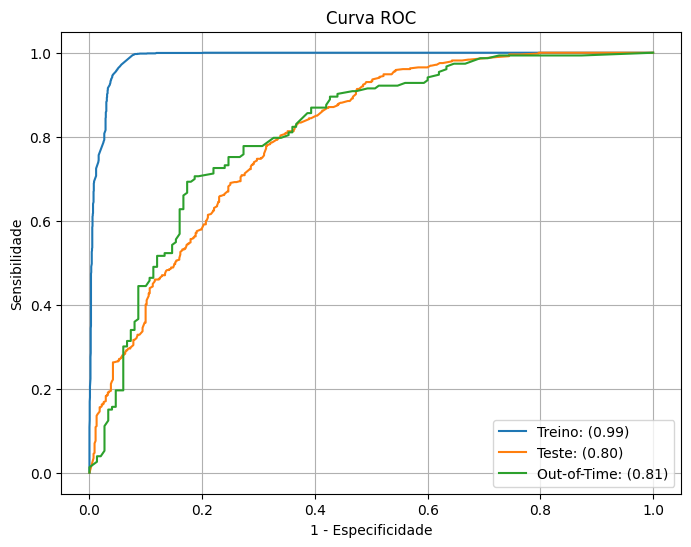

In [22]:
# =============================================================================
# VISUALIZAÇÃO DA CURVA ROC
# =============================================================================

plt.figure(figsize=(8, 6))
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_oot[0], roc_oot[1])
plt.grid(True)
plt.ylabel("Sensibilidade")
plt.xlabel("1 - Especificidade")
plt.title('Curva ROC')
plt.legend([
    f"Treino: ({auc_train:.2f})", 
    f"Teste: ({auc_test:.2f})", 
    f"Out-of-Time: ({auc_oot:.2f})",
])

plt.show()

In [23]:
model_df = pd.Series({
    "model": model_pipeline,
    "features": best_features,
})

model_df.to_pickle("model.pkl")